# Exploratory Data Analysis ENEM2019 v1.0

This notebook will contain an exploratory data analysis (EDA) of ENEM2019 (last year before COVID-19) dataset, one of the most important steps in any data science project. The goal of this notebook is to provide a quick overview of the data and the methods used to explore it. 

## 1. Imports

In [96]:
import pandas as pd
import os 
import numpy as np 
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
sns.set_palette('Paired')
sns.set_style("whitegrid")
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['font.size'] = 14

## 2. Reading Data

In [20]:
processed_directory = sorted(filter(lambda dir: '.parquet' in dir, os.listdir('../data/processed')), reverse = True)[0]
processed_directory = '../data/processed/' + processed_directory

data = pd.read_parquet(processed_directory).query('enem_year == 2019')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50873 entries, 54823 to 105695
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           50873 non-null  int64  
 1   enem_year                    50873 non-null  int64  
 2   age                          50873 non-null  object 
 3   sex                          50873 non-null  object 
 4   marital_status               50873 non-null  object 
 5   color_race                   50873 non-null  object 
 6   high_school_status           50873 non-null  object 
 7   year_completion_high_school  50873 non-null  int64  
 8   school_type                  50873 non-null  object 
 9   id_city_school               11461 non-null  float64
 10  city_school                  11461 non-null  object 
 11  state_school                 11461 non-null  object 
 12  id_city_test                 50873 non-null  int64  
 13  city_test  

In [22]:
cities = pd.read_csv('../data/external/cities.csv', sep = ';', usecols = ['ibge_code', 'lat_city', 'long_city', 'capital', 'state_lat', 'state_long', 'region'])
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ibge_code   5570 non-null   int64  
 1   lat_city    5570 non-null   float64
 2   long_city   5570 non-null   float64
 3   capital     5570 non-null   int64  
 4   state_lat   5570 non-null   float64
 5   state_long  5570 non-null   float64
 6   region      5570 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 304.7+ KB


In [23]:
# Joining the candidates data and cities info
data = data.merge(cities, left_on = 'id_city_test', right_on = 'ibge_code')

## 3. Exploratory Data Analysis

### 3.1 Check NULL Values

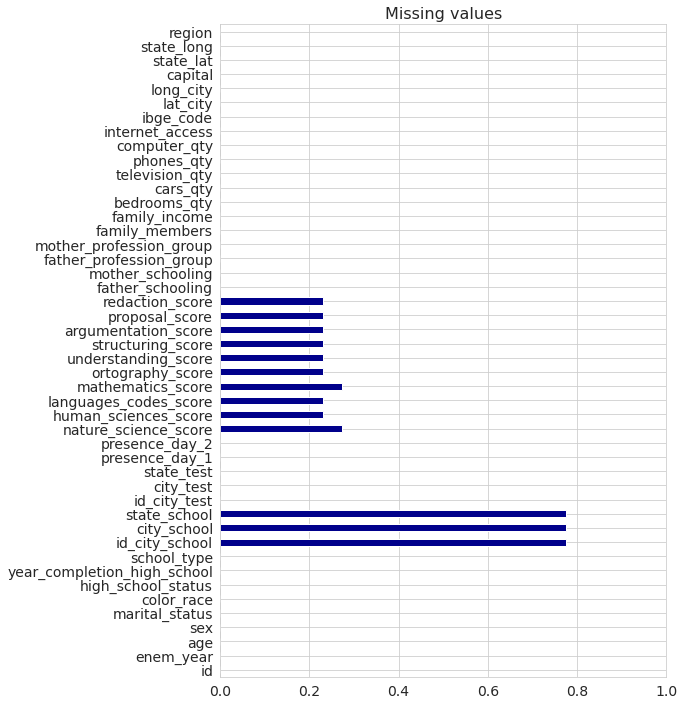

In [24]:
(data.isna().sum() / data.shape[0]).plot.barh(figsize = (8, 12), color = 'darkblue')

plt.title('Missing values', fontsize = 16)
plt.xlim(0, 1.0)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missing_values.jpeg', bbox_inches = 'tight', dpi = 600) 
plt.show()

The dataset has a lot of missing values. Especially in score data and id_city_school. In the first case, it occurs because the score data is not filled if the student didn't take the test. In the second case, seems that is mandatory to fill this field only the candidates that high_school_status is equal to "Ends in the current year".

*  The id_city_school will be removed from the dataset because it is not useful for the modelling;
*  The candidates that have null values in score data will be removed from the dataset;

### 3.2 Missed Candidates

### 3.2.1 By Family Income

In [25]:
# family_income label ordered

income_order = [
  'No income',
  'Less than 1 minimum wage',
  'Between 1-1.5 minimum wages',
  'Between 1.5-2 minimum wages',
  'Between 2-2.5 minimum wages',
  'Between 2.5-3 minimum wages',
  'Between 3-4 minimum wages',
  'Between 4-5 minimum wages',
  'Between 5-6 minimum wages',
  'Between 6-7 minimum wages',
  'Between 7-8 minimum wages',
  'Between 8-9 minimum wages',
  'Between 9-10 minimum wages',
  'Between 10-12 minimum wages',
  'Between 12-15 minimum wages',
  'Between 15-20 minimum wages',
  'More than 20 minimum wages'
]

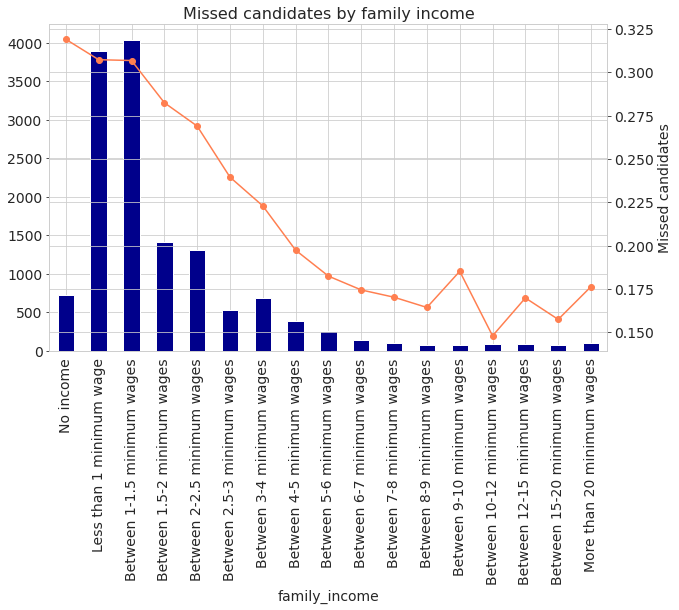

In [26]:
# missed in either first or second day of test
missed_candidates = data.query('(presence_day_1 + presence_day_2) != 2')

# grouping by family income
missed_candidates_family_income = missed_candidates.groupby('family_income').size()[income_order]
total_candidates = data.groupby('family_income').size()[income_order]

# count of missed candidates
bar_plot = missed_candidates_family_income.plot.bar(figsize = (8, 6), color = 'darkblue')

# relative missed candidates
line_plot = bar_plot.twinx()
(missed_candidates_family_income / total_candidates).plot(figsize = (10, 6), color = 'coral', marker = 'o', ax = line_plot)

plt.title('Missed candidates by family income', fontsize = 16)
plt.ylabel('Missed candidates')
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_family_income.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.2.2 By Color and Race

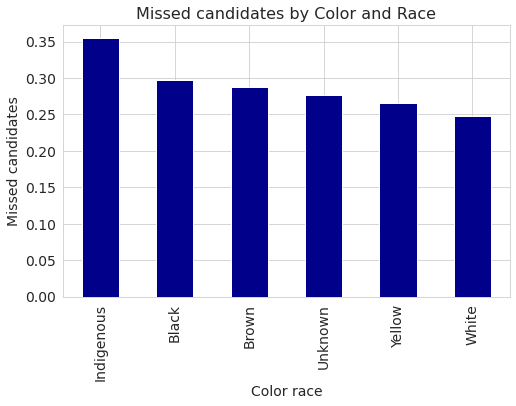

In [27]:
missed_candidates_color_race = missed_candidates.groupby('color_race').size()
total_candidates = data.groupby('color_race').size()

# count of missed candidates
bar_plot = (missed_candidates_color_race / total_candidates).sort_values(ascending = False).plot.bar(figsize = (8, 5), color = 'darkblue')

plt.title('Missed candidates by Color and Race', fontsize = 16)
plt.xlabel('Color race')
plt.ylabel('Missed candidates')
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_color_race.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.2.3 By State

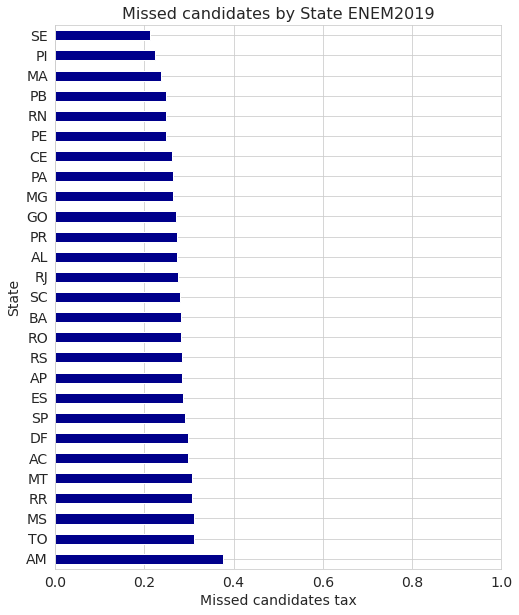

In [28]:
missed_candidates_state_test = missed_candidates.groupby('state_test').size()
total_candidates = data.groupby('state_test').size()

# count of missed candidates
bar_plot = (missed_candidates_state_test / total_candidates).sort_values(ascending = False).plot.barh(figsize = (8, 10), color = 'darkblue')

plt.title('Missed candidates by State ENEM2019', fontsize = 16)
plt.xlabel('Missed candidates tax')
plt.ylabel('State')
plt.xlim(0, 1.0)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_state.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

As we can see in the two graphs above, the candidates that live nearby the Amazônia Forest (in the North: AM and RO states) have more difficulty attending the test:
* In the first graph (3.2.2), AM contains more candidates that live near the Amazônia Forest, tagged as (Indigenous color and race);
* In the second graph (3.2.3), AM and RO have 

### 3.2.4 By School Type

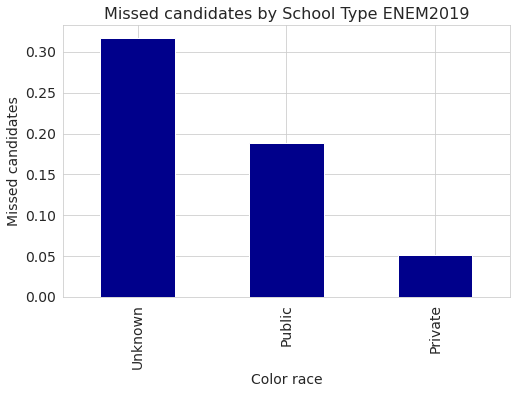

In [29]:
missed_candidates_school_type = missed_candidates.groupby('school_type').size()
total_candidates = data.groupby('school_type').size()

# count of missed candidates
bar_plot = (missed_candidates_school_type / total_candidates).sort_values(ascending = False).plot.bar(figsize = (8, 5), color = 'darkblue')

plt.title('Missed candidates by School Type ENEM2019', fontsize = 16)
plt.xlabel('Color race')
plt.ylabel('Missed candidates')
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_school_type.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.2.5 By Sex

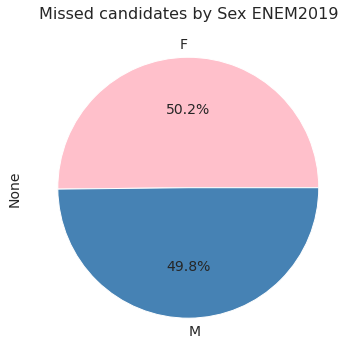

In [30]:
missed_candidates_sex = missed_candidates.groupby('sex').size()
total_candidates = data.groupby('sex').size()

# count of missed candidates
bar_plot = (missed_candidates_sex / total_candidates).plot.pie(figsize = (6, 6), autopct = '%1.1f%%', colors = ['pink', 'steelblue'])

plt.title('Missed candidates by Sex ENEM2019', fontsize = 16)
plt.xlabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/missed_candidates_by_sex.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.3 School Type Distribution

In [31]:
# filter out candidates that failed in ENEM in one of the two days
# each presence day has value 1 then (presence_day_1 + presence_day_2) is equal 2
present_candidates = data.query('(presence_day_1 + presence_day_2) == 2')
present_candidates.head(5)

,id,enem_year,age,sex,marital_status,color_race,high_school_status,year_completion_high_school,school_type,id_city_school,city_school,state_school,id_city_test,city_test,state_test,presence_day_1,presence_day_2,nature_science_score,human_sciences_score,languages_codes_score,mathematics_score,ortography_score,understanding_score,structuring_score,argumentation_score,proposal_score,redaction_score,father_schooling,mother_schooling,father_profession_group,mother_profession_group,family_members,family_income,bedrooms_qty,cars_qty,television_qty,phones_qty,computer_qty,internet_access,ibge_code,lat_city,long_city,capital,state_lat,state_long,region
0,190001004687,2019,18 years-old,F,Single,Brown,Completed High School,1,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,349.8,417.1,416.6,468.3,120.0,40.0,40.0,120.0,0.0,320.0,Completed Elementary School,Completed Elementary School,Group C,Group B,4.0,Less than 1 minimum wage,Two,No,One,No,No,No,1500800,-1.36391,-48.3743,0,-3.79,-52.48,Norte
1,190001007110,2019,18 years-old,F,Single,White,Ends in the current year,0,Public,1500800.0,Ananindeua,PA,1500800,Ananindeua,PA,1.0,1.0,524.5,544.7,545.4,458.1,160.0,120.0,140.0,140.0,140.0,700.0,Completed High School,Didn't complete Elementary School,Group F,Group F,6.0,Between 1-1.5 minimum wages,Two,No,One,Four or more,One,Yes,1500800,-1.36391,-48.3743,0,-3.79,-52.48,Norte
2,190001007346,2019,20 years-old,F,Single,White,Completed High School,3,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,521.4,514.7,615.5,699.8,120.0,120.0,140.0,160.0,140.0,680.0,Completed Elementary School,Completed College,Group C,Group D,4.0,Between 8-9 minimum wages,Three,No,Three,Three,One,Yes,1500800,-1.36391,-48.3743,0,-3.79,-52.48,Norte
4,190001007985,2019,Less than 17 years-old,M,Single,Brown,Will complete High School the following year,0,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,598.0,613.6,592.0,709.7,160.0,200.0,160.0,160.0,200.0,880.0,Completed High School,Completed High School,Group D,Group D,5.0,Between 3-4 minimum wages,Three,One,One,Three,Two,No,1500800,-1.36391,-48.3743,0,-3.79,-52.48,Norte
5,190001009480,2019,Less than 17 years-old,F,Single,White,Will complete High School the following year,0,Unknown,NaN,None,None,1500800,Ananindeua,PA,1.0,1.0,527.1,705.7,656.8,603.3,160.0,120.0,140.0,180.0,140.0,740.0,Completed High School,Completed High School,Group B,Group B,4.0,Less than 1 minimum wage,One,No,One,No,No,No,1500800,-1.36391,-48.3743,0,-3.79,-52.48,Norte


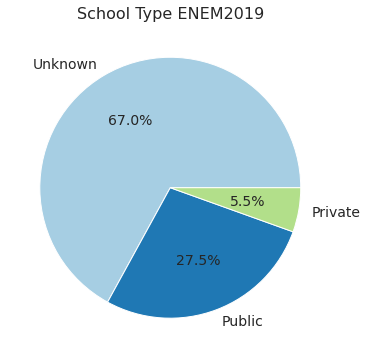

In [32]:
present_candidates.school_type.value_counts().plot.pie(figsize = (6, 6), autopct = '%1.1f%%')

plt.title('School Type ENEM2019', fontsize = 16)
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_type_all_candidates.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

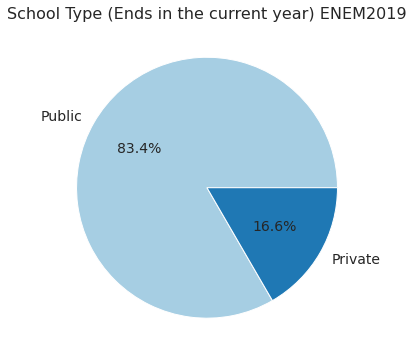

In [33]:
present_candidates.query('high_school_status == "Ends in the current year"').school_type.value_counts().plot.pie(figsize = (6, 6), autopct = '%1.1f%%')

plt.title('School Type (Ends in the current year) ENEM2019', fontsize = 16)
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_type_ends_current_year.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

As explained in the previous observation, the school_type variable is filled just if the student is a high school student. The majority of the candidates study in public high schools.

### 3.4 Sex Distribution


#### 3.4.1 All dataset

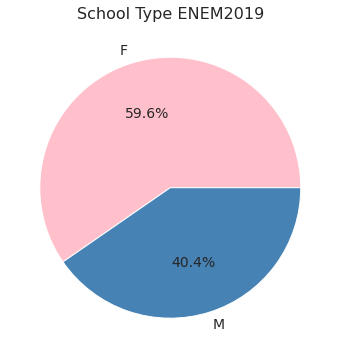

In [34]:
data.sex.value_counts().plot.pie(figsize = (6, 6), autopct = '%1.1f%%', colors = ['pink', 'steelblue'])

plt.title('School Type ENEM2019', fontsize = 16)
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_type_sex.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

Most candidates in our dataset are women but don't have a big difference between these two classes.

#### 3.4.2 Presents By Family Income

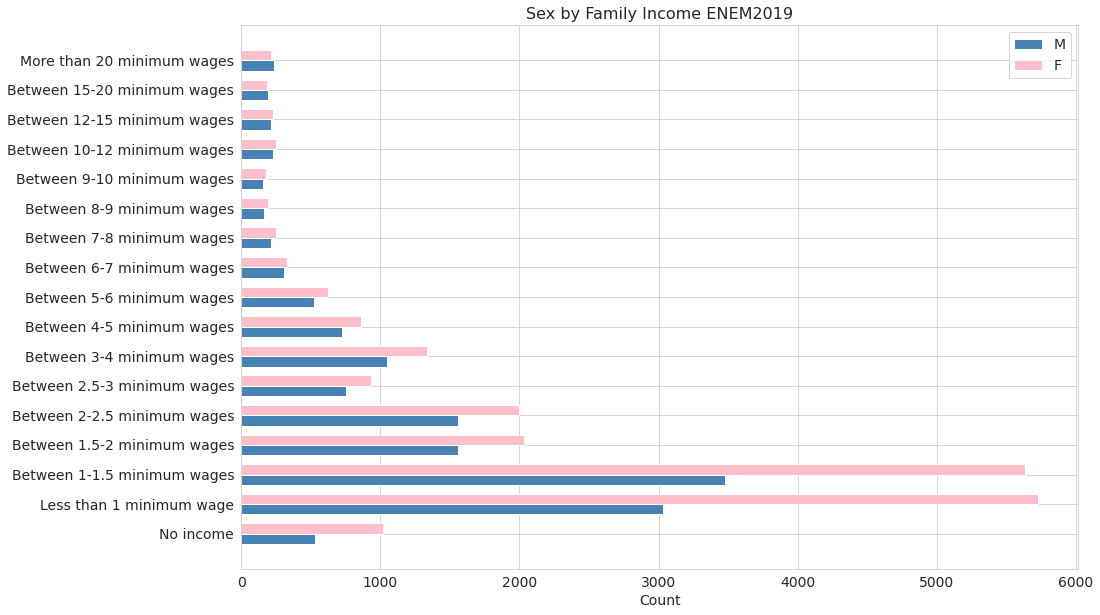

In [35]:
sex_family_income_presents = present_candidates.groupby(['family_income', 'sex']).size()[income_order]

# number of men and women splited
men = sex_family_income_presents.loc[(income_order, 'M')].values
women = sex_family_income_presents.loc[(income_order, 'F')].values

fig, ax = plt.subplots(figsize = (15, 10))
men_bars = ax.barh(np.arange(len(income_order)) - 0.35 / 2, men, 0.35, label = 'M', color = 'steelblue')
women_bars = ax.barh(np.arange(len(income_order)) + 0.35 / 2, women, 0.35, label = 'F', color = 'pink')

# plot labels
ax.set_title('Sex by Family Income ENEM2019', fontsize = 16)
ax.set_xlabel('Count')
ax.legend()

# seting the income in y ticks
ax.set_yticks(np.arange(len(income_order)), income_order)

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/present_candidates_sex_family_income.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

There is a high concentration of female candidates with low family income. But as we can see, how much bigger the income family, the more the difference between the gender decrease.

## 3.4 Cities and States Distribution

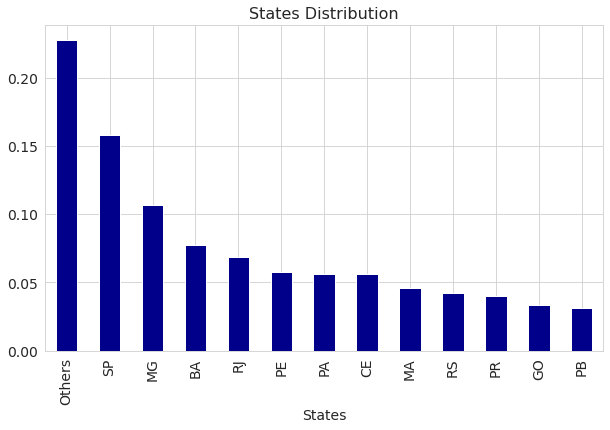

In [36]:
less_frequent = present_candidates.state_test.value_counts().tail(15)

less_to_others = {state: 'Others' for state in less_frequent.index}
present_candidates.state_test.replace(less_to_others).value_counts(normalize = True).plot.bar(figsize = (10, 6), color = 'darkblue')

plt.title('States Distribution', fontsize = 16)
plt.xlabel('States')
plt.ylabel(None)
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/states-distribution.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

### 3.4.3 School and Test Cities

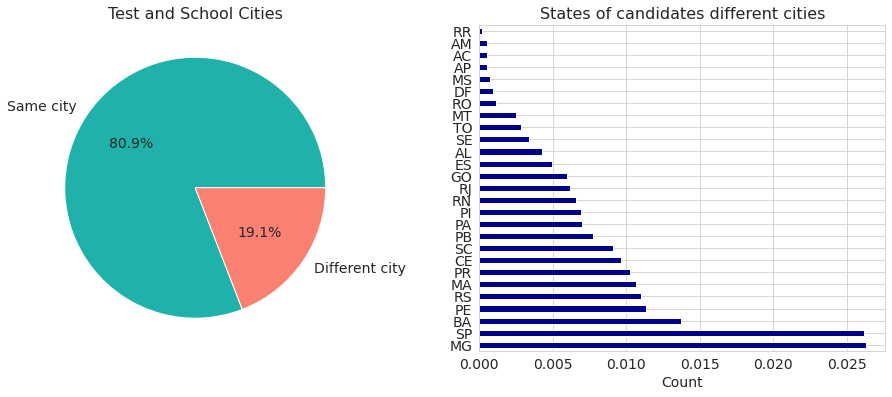

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

# remove some candidates that don't have city school
school_test_city = present_candidates[present_candidates.city_school.notnull()]

# pie plot
school_test_city.eval('city_school == city_test').replace({
    True: 'Same city', 
    False: 'Different city'
}).value_counts().plot.pie(autopct = '%1.1f%%', colors = ['lightseagreen', 'salmon'], ax = ax[0])
ax[0].set_title('Test and School Cities', fontsize = 16)
ax[0].set_ylabel(None)

# barh plot
(school_test_city.query('city_school != city_test').state_school.value_counts()/school_test_city.shape[0]).plot.barh(color = 'darkblue', ax = ax[1])
ax[1].set_title('States of candidates different cities', fontsize = 16)
ax[1].set_xlabel('Count')

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/school_test_same_city.jpeg', bbox_inches = 'tight', dpi = 600)
plt.show()

Most of the candidates present take the test in the same city where they live. In the right graph we can notice that MG state have the major candidates that take the test in different city.

## 3.5 Scores

### 3.5.1 Selecting Score

In [87]:
present_candidates[['nature_science_score', 'human_sciences_score', 'languages_codes_score', 'mathematics_score', 'redaction_score']].var().to_frame(name = 'variance')

,variance
nature_science_score,5750.560777
human_sciences_score,6574.418186
languages_codes_score,3878.654698
mathematics_score,11931.510044
redaction_score,33353.198670


As we can see, the mathematics_score and redaction_score have a higher variance, so we can use these variables to build our proxy variable to be used as a target to our study and ML model.

In [40]:
present_candidates[['mathematics_score', 'redaction_score']].describe()

,mathematics_score,redaction_score
count,36901.000000,36901.000000
mean,523.388922,580.162055
std,109.231452,182.628581
min,0.000000,0.000000
25%,434.900000,500.000000
50%,501.100000,580.000000
75%,598.300000,680.000000
max,971.700000,1000.000000


In [192]:
n_values = 21
pd.DataFrame([
    present_candidates.mathematics_score.quantile(np.linspace(0, 1, n_values)),
    present_candidates.redaction_score.quantile(np.linspace(0, 1, n_values))
])

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
mathematics_score,0.0,383.6,398.5,410.8,423.2,434.9,446.8,459.3,472.4,486.3,501.1,517.3,535.3,554.9,576.1,598.3,622.2,647.7,680.5,726.7,971.7
redaction_score,0.0,280.0,360.0,420.0,460.0,500.0,520.0,540.0,560.0,560.0,580.0,600.0,620.0,640.0,660.0,680.0,720.0,760.0,820.0,880.0,1000.0


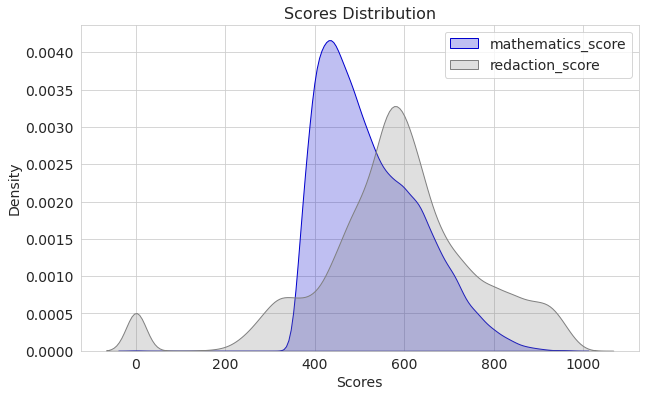

In [195]:
plt.figure(figsize = (10, 6))

sns.kdeplot(present_candidates.mathematics_score, fill = True, color = 'mediumblue')
sns.kdeplot(present_candidates.redaction_score, fill = True, color = 'grey')

plt.title('Scores Distribution', fontsize = 16)
plt.xlabel('Scores')

plt.legend(['mathematics_score', 'redaction_score'])
plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem/missed_candidates_math_red_scores.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()

Is important to note that the mathematics_score don't follom a Normal Distribution, so we must to use Median as a Central Tendency.

### 3.5.2 Building proxy variable (Target)

We consider all candidates that have a mathematics score major or equal to 90% percentile as "approved" in the test. This will be our proxy variable to determine how many candidates were entered into a Federal University.

In [76]:
present_candidates['approved'] = np.where(present_candidates.mathematics_score >= present_candidates.mathematics_score.quantile(0.90), 1, 0)
present_candidates.iloc[:, -5:]

/tmp/ipykernel_11212/2426088829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  present_candidates['approved'] = np.where(present_candidates.mathematics_score >= present_candidates.mathematics_score.quantile(0.90), 1, 0)


,state_lat,state_long,region,target,approved
0,-3.79,-52.48,Norte,0,0
1,-3.79,-52.48,Norte,0,0
2,-3.79,-52.48,Norte,1,1
4,-3.79,-52.48,Norte,1,1
5,-3.79,-52.48,Norte,0,0
...,...,...,...,...,...
50866,-3.47,-65.10,Norte,0,0
50869,-8.38,-37.86,Nordeste,0,0
50870,1.99,-61.33,Norte,0,0
50871,1.99,-61.33,Norte,0,0


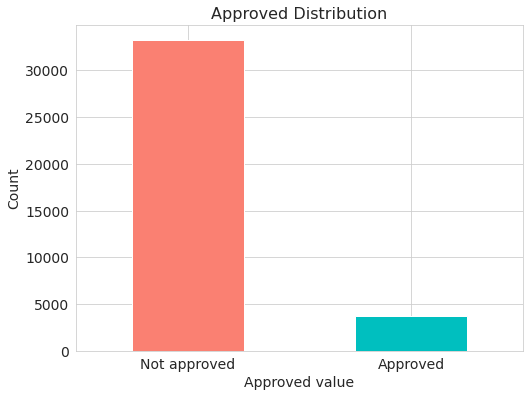

In [77]:
present_candidates.approved.value_counts().plot.bar(figsize = (8, 6), color = ['salmon', 'c'], rot = 0)

plt.title('Approved Distribution', fontsize = 16)
plt.xlabel('Approved value')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not approved', 'Approved'])

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/approved_distribution.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()

## 3.6 Approved Descritive Analysis

As the approved is a binary data, so we can use mean to calculate the rate. Example: <br>
* ```mean([1, 1, 0]) = 0.66```<br>
* ```mean([1, 1, 1, 0]) = 0.75```<br>

### 3.6.1 By Family Income

In [97]:
present_candidates.groupby('family_income').approved.mean().to_frame()

,approved
family_income,
Between 1-1.5 minimum wages,0.037846
Between 1.5-2 minimum wages,0.072423
Between 10-12 minimum wages,0.374477
Between 12-15 minimum wages,0.443182
Between 15-20 minimum wages,0.486842
Between 2-2.5 minimum wages,0.091906
Between 2.5-3 minimum wages,0.141414
Between 3-4 minimum wages,0.151617
Between 4-5 minimum wages,0.195460


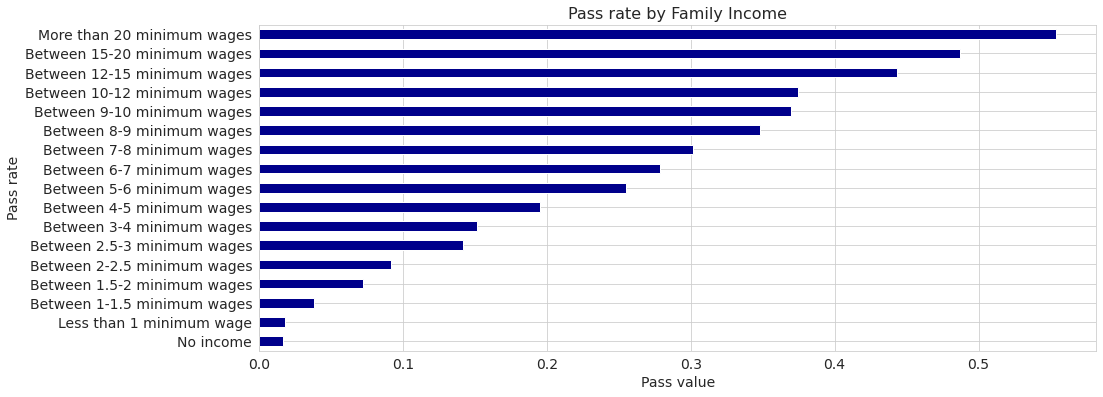

In [89]:
present_candidates.groupby('family_income').approved.mean().sort_values().plot.barh(figsize = (15, 6), color = 'darkblue')

plt.title('Pass rate by Family Income', fontsize = 16)
plt.xlabel('Pass value')
plt.ylabel('Pass rate')

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/approved_by_family_income.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()

### 3.6.2 By Color and Race

In [88]:
present_candidates.groupby('color_race').approved.mean().sort_values(ascending = False).to_frame()

,approved
color_race,
White,0.163164
Unknown,0.137004
Yellow,0.116723
Brown,0.063128
Indigenous,0.055556
Black,0.037175


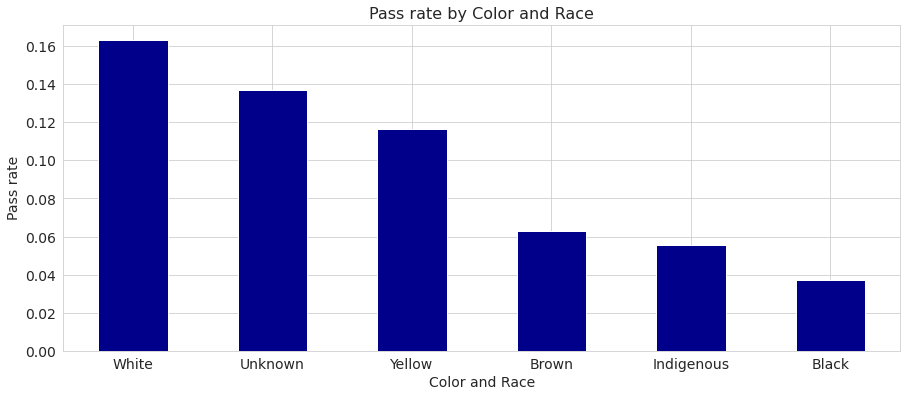

In [91]:
present_candidates.groupby('color_race').target.mean().sort_values(ascending = False).plot.bar(figsize = (15, 6), color = 'darkblue', rot = 0)

plt.title('Pass rate by Color and Race', fontsize = 16)
plt.xlabel('Color and Race')
plt.ylabel('Pass rate')

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/approved_by_color_race.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()

### 3.6.3 By State

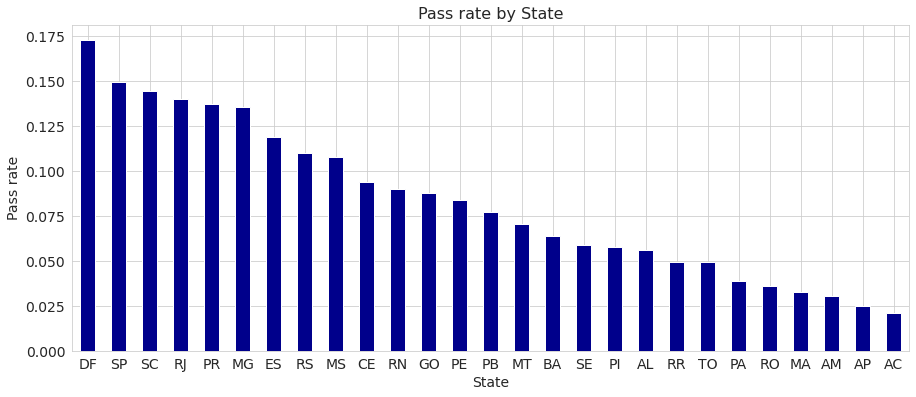

In [92]:
present_candidates.groupby('state_test').target.mean().sort_values(ascending = False).plot.bar(figsize = (15, 6), color = 'darkblue', rot = 0)

plt.title('Pass rate by State', fontsize = 16)
plt.xlabel('State')
plt.ylabel('Pass rate')

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/approved_by_state.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()

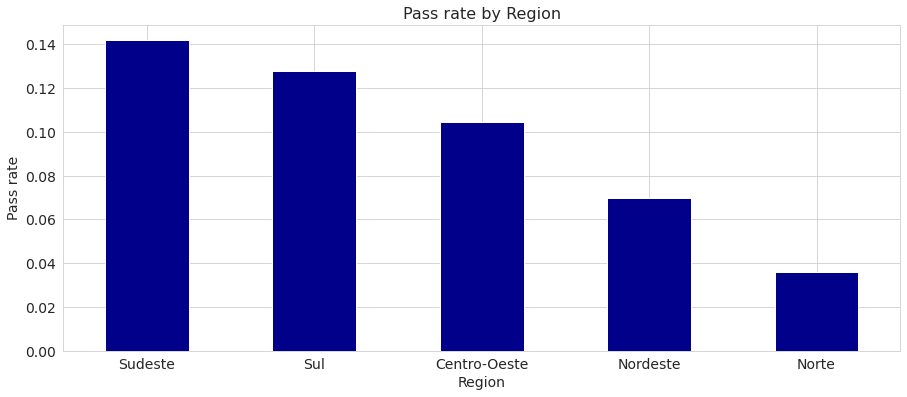

In [94]:
present_candidates.groupby('region').target.mean().sort_values(ascending = False).plot.bar(figsize = (15, 6), color = 'darkblue', rot = 0)

plt.title('Pass rate by Region', fontsize = 16)
plt.xlabel('Region')
plt.ylabel('Pass rate')

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/approved_by_region.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()

### 3.6.4 By Age

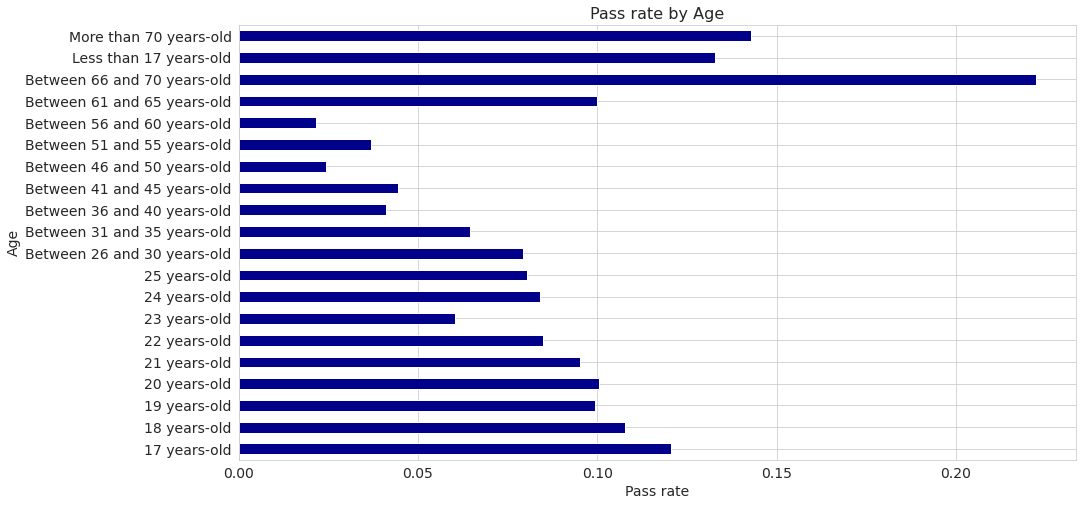

In [123]:
present_candidates.groupby('age').target.mean().plot.barh(figsize = (15, 8), color = 'darkblue')

plt.title('Pass rate by Age', fontsize = 16)
plt.xlabel('Pass rate')
plt.ylabel('Age')

plt.savefig('../reports/figures/1.0-exploratory-data-analysis-enem2019/approved_by_age.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()